In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from load_dataset import Dataset
import plotting

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dataset = Dataset('../data/Dataset')

In [18]:
ts = dataset['international-airline-passengers.csv']
ts.index = ts.index.map(pd.to_datetime)

In [19]:
ts, ts_test = ts[:100], ts[100:]

<AxesSubplot:xlabel='1949-01'>

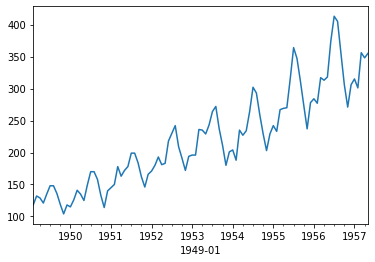

In [20]:
ts.plot()

In [21]:
ts.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01',
               '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01',
               '1949-10-01', '1949-11-01', '1949-12-01', '1950-01-01',
               '1950-02-01', '1950-03-01', '1950-04-01', '1950-05-01',
               '1950-06-01', '1950-07-01', '1950-08-01', '1950-09-01',
               '1950-10-01', '1950-11-01', '1950-12-01', '1951-01-01',
               '1951-02-01', '1951-03-01', '1951-04-01', '1951-05-01',
               '1951-06-01', '1951-07-01', '1951-08-01', '1951-09-01',
               '1951-10-01', '1951-11-01', '1951-12-01', '1952-01-01',
               '1952-02-01', '1952-03-01', '1952-04-01', '1952-05-01',
               '1952-06-01', '1952-07-01', '1952-08-01', '1952-09-01',
               '1952-10-01', '1952-11-01', '1952-12-01', '1953-01-01',
               '1953-02-01', '1953-03-01', '1953-04-01', '1953-05-01',
               '1953-06-01', '1953-07-01', '1953-08-01', '1953-09-01',
      

#### Задание 1. Box-Jenkins approach
1. Убрать гетероскедастичность при помощи логарифмирования.
2. Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя
   получившийся ряд при помощи графика acf_plot.
3. Оценить параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.
4. Обучить модель SARIMA и попробовать сделать предсказания исходного ряда.
5. Критерий хорошей модели - около-стационарные остатки.

In [22]:
ts_log = np.log(ts)

<AxesSubplot:xlabel='1949-01'>

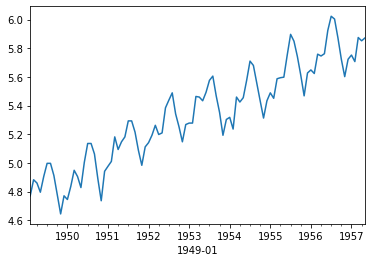

In [23]:
ts_log.plot()

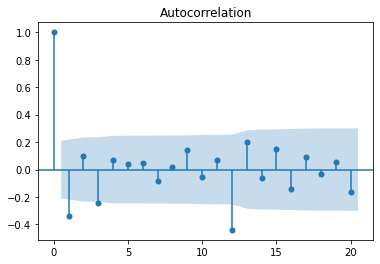

In [70]:
plot_acf(ts_log.diff(12).diff(1).dropna());
# q, Q = (1, 1)

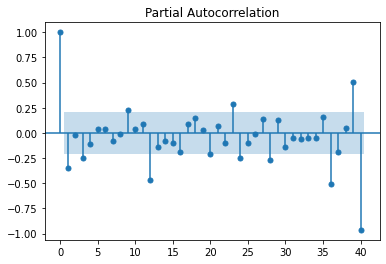

In [71]:
plot_pacf(ts_log.diff(12).diff().dropna(), lags=40);
# (p, P) = (0, 0)

In [72]:
from statsmodels.tsa.statespace import sarimax

In [88]:
pdq = (0, 1, 1)
PDQ = (0, 1, 1, 12)
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

/Users/gsinyakov/ts_summer/.env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gsinyakov/ts_summer/.env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [89]:
res = model.fit()

In [90]:
preds = res.forecast(len(ts_test))

In [91]:
plotting.plot_ts(ts, np.exp(preds), ts_test)

Loading BokehJS ...

In [92]:
from sklearn.metrics import r2_score, mean_squared_error

In [93]:
r2_score(ts_test, np.exp(preds))

0.6826086019943298

In [94]:
mean_squared_error(ts_test, np.exp(preds))

1865.0234393309845

In [95]:
res = np.exp(preds) - ts_test

<AxesSubplot:>

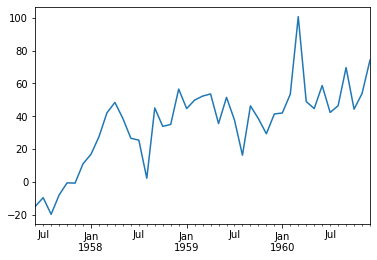

In [96]:
res.plot()

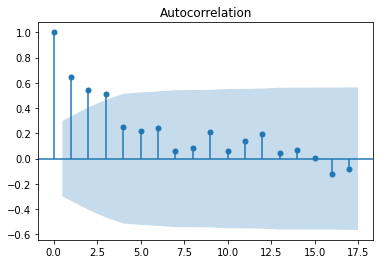

In [98]:
plot_acf(res);

In [99]:
adfuller(res)

(-2.396996397452361,
 0.142585948550575,
 8,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 267.6070433920161)

#### Пара выводов
* Мы наблюдаем остаточный тренд в остатках предсказания, который связан с нелинейным трендом исходного ряда, чтобы получить еще более качественный прогноз, стоит аппроксимировать ряд, например, полиномом второй степени.
* Учитывая out-of-sample прогноз (на несколько точек вперед) и малое количество данных для обучения, подход arima к прогнозированию таких коротких одномерных рядов очень сложно побить современными методами, как мы в дальнейшем увидим
* графики acf/pacf являются лишь приблизительным правилом нахождения pPqQ, и не всегда являются оптимальными сразу, как в нашем примере, финальные параметры обычно подбираются прохождением "по сетке" и оценке целевой метрики (mse, rmse, mae и тп)

#### Задание 2. (используя критерий Акаике)
1. Выбрать сетку гиперпараметров.
2. Пройтись по сетке, обучая модель и считая aic на тестовой выборке.
3. Выбрать модель с набором гиперпараметров, дающих минимальный aic. 

In [28]:
import itertools

p, q = range(0, 3), range(0, 3)
d = [1, 1]
pdq = list(itertools.product(p, d, q))

PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
from numpy.linalg.linalg import LinAlgError


for pdq_, PDQ_ in zip(pdq, PDQ):
    model = sarimax.SARIMAX(ts_log, order=pdq_, seasonal_order=PDQ_)
    res = model.fit()
    try:
        print(pdq_, PDQ_)
        print(res.aic)
    except BaseException as e:
        continue

(0, 1, 0) (0, 1, 0, 12)
-274.96600868674113
(0, 1, 1) (0, 1, 1, 12)
-309.68631139902664
(0, 1, 2) (0, 1, 2, 12)
-306.1993795909624
(0, 1, 0) (0, 1, 0, 12)
-274.96600868674113
(0, 1, 1) (0, 1, 1, 12)
-309.68631139902664
(0, 1, 2) (0, 1, 2, 12)
-306.1993795909624
(1, 1, 0) (1, 1, 0, 12)
-302.3707763542672
(1, 1, 1) (1, 1, 1, 12)
-306.5441717927238
(1, 1, 2) (1, 1, 2, 12)
-301.8476885759598
(1, 1, 0) (1, 1, 0, 12)
-302.3707763542672
(1, 1, 1) (1, 1, 1, 12)
-306.5441717927238
(1, 1, 2) (1, 1, 2, 12)
-301.8476885759598
(2, 1, 0) (2, 1, 0, 12)
-303.01656947801115
(2, 1, 1) (2, 1, 1, 12)
-302.9789719329181
(2, 1, 2) (2, 1, 2, 12)
-300.0983986138764
(2, 1, 0) (2, 1, 0, 12)
-303.01656947801115
(2, 1, 1) (2, 1, 1, 12)
-302.9789719329181
(2, 1, 2) (2, 1, 2, 12)
-300.0983986138764


#### Задание 3. (используя auto-arima)
1. Установить аналог auto-arima из R, библиотеку pmdarima (pip install pmdarima)
2. Обучить модель, используя функцию auto_arima, передав в нее нужные параметры.

In [100]:
from pmdarima import auto_arima

In [32]:
model = auto_arima(
     ts_log, start_p=0, start_q=0,
     max_p=3, max_q=3, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=1, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-274.966, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-302.371, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-309.686, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-284.621, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-307.867, Time=0.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-307.883, Time=0.64 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-304.096, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-305.846, Time=0.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-300.816, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-308.392, Time=0.34 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-307.997, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-308.460, Time=0.15 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-305.688, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-307.709, Time=0.41 sec

Best model:  ARIMA

In [33]:
model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)